In [286]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('./static/result.csv')

df.head()

replacement_ans = {
    "Agree": 1,
    "Unsure": 0,
    "Disagree": -1,    
}

replacement_conf = {
    "7-Extremely confident": 7,
    "6-Very confident": 6,
    "5-Somewhat confident": 5,
    "4-Neutral": 4,
    "3-Somewhat lacking confidence": 3,
    "2-Very lacking confidence": 2,
    "1-Extremely lacking confidence": 1,
}

condition = [
    "control",
    "ai-edited-image",
    "ai-edited-video",
    "ai-edited-image-video",
]

induced = [1,2,3,4,9,10,11,12,17,18,19,20]
non_induced_imgs = [5,6,7,8,13,14,15,16,21,22,23,24]

correct_is_true = [6,7,9,10,14,18,21,23]
correct_is_false = [1,2,3,4,5,8,11,12,13,15,16,17,19,20,22,24]

# get filtered columns
filtered_cols = [[f"{i}_false_memories_ans", f"{i}_false_memories_conf"] for i in [*range(1,25)]]
filtered_cols = [i for sublist in filtered_cols for i in sublist]

# remove headers and replace values
head = df.head(1)
df = df[2:][['condition', *filtered_cols]]
df.replace(replacement_ans, inplace=True)
df.replace(replacement_conf, inplace=True)

result = df.copy()
result = result[['condition'] + [f"{i}_false_memories_ans" for i in [*range(1,25)]]  + [f"{i}_false_memories_conf" for i in [*range(1,25)]]]

for i in [*range(1,25)]:
    multiplier = 1 if i in correct_is_true else -1
    result[f"{i}_false_memories_ans"] *= multiplier
    
# result -> 1 = true memory / 0 = unsure / -1 = false memory
# result[[f"{i}_false_memories_ans" for i in [*range(1,25)] if i in induced]]

/var/folders/bw/64y3yr9n6v50fgm86wtx236c0000gn/T/ipykernel_4930/3196060024.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(replacement_ans, inplace=True)
/var/folders/bw/64y3yr9n6v50fgm86wtx236c0000gn/T/ipykernel_4930/3196060024.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(replacement_conf, inplace=True)


In [194]:
def summarize(cat, df):
    # get sum
    df['overall'] = df[[f"{i}_false_memories_ans" for i in [*range(1,25)]]].sum(axis=1)
    df['induced'] = df[[f"{i}_false_memories_ans" for i in [*range(1,25)] if i in induced]].sum(axis=1)
    df['non induced'] = df[[f"{i}_false_memories_ans" for i in [*range(1,25) ] if i in non_induced_imgs]].sum(axis=1)

    # get percentages in % in two decimals
    df['overall %'] = (df['overall'] / 24) * 100
    df['induced %'] = (df['induced'] / 12) * 100
    df['non induced %'] = (df['non induced'] / 12) * 100

    # filter
    df = df[['condition', 'overall', 'overall %', 'induced', 'induced %', 'non induced', 'non induced %']]

    print(cat)
    display(df.groupby('condition').mean().round(2))
    
true_memories = result.copy().replace(-1,0)
false_memories = result.copy().replace(1,0).replace(-1,1)
unsure_memories = result.copy().replace(1,-1).replace(0,1).replace(-1,0)
summarize('Non False Memories', true_memories)
summarize('Unsure Memories', unsure_memories)
summarize('False Memories', false_memories)

In [ ]:
def confidence(cat, result, raw):
    print(cat)
    # display(result)
    # display(raw[['condition', *[f"{i}_false_memories_conf" for i in [*range(1,25)]]]])
    
    # get confidence: for each row {i}_confidence = result[{i}_false_memories_ans] * raw[{i}_false_memories_conf]
    for i in [*range(1,25)]:
        result[f"{i}_conf"] = result[f"{i}_false_memories_ans"] * raw[f"{i}_false_memories_conf"]
    
    result['overall'] = result[[f"{i}_conf" for i in [*range(1,25)]]].sum(axis=1) / 14
    result['induced'] = result[[f"{i}_conf" for i in [*range(1,25)] if i in induced]].sum(axis=1) / 7
    result['non induced'] = result[[f"{i}_conf" for i in [*range(1,25)] if i in non_induced_imgs]].sum(axis=1) / 7

    result = result[['condition', 'overall', 'induced', 'non induced']]
    display(result.groupby('condition').mean().round(2))
        
true_memories = result.copy().replace(-1,0)
false_memories = result.copy().replace(1,0).replace(-1,1)

confidence("Non False Memories", true_memories, df)
confidence("False Memories", false_memories, df)

In [287]:
score = pd.DataFrame()

# for each row in df, multiply answer by confidence
for i in [*range(1,25)]:
    multiplier = -1 if i in correct_is_false else 1
    score['condition'] = df['condition']
    score[f"{i}_false_memories_score"] = multiplier * df[f"{i}_false_memories_ans"] * df[f"{i}_false_memories_conf"]
    score[f"{i}_false_memories_no"] = multiplier * df[f"{i}_false_memories_ans"]

# sum scores    
score['overall'] = score[[f"{i}_false_memories_score" for i in [*range(1,25)]]].sum(axis=1)
score['induced'] = score[[f"{i}_false_memories_no" for i in [*range(1,25)] if i in induced]].sum(axis=1)
score['weighted induced'] = score[[f"{i}_false_memories_score" for i in [*range(1,25)] if i in induced]].sum(axis=1)
score['non induced'] = score[[f"{i}_false_memories_no" for i in [*range(1,25)] if i in non_induced_imgs]].sum(axis=1)
score['weighted non induced'] = score[[f"{i}_false_memories_score" for i in [*range(1,25)] if i in non_induced_imgs]].sum(axis=1)

cond = ['condition', 'overall', 'induced', 'weighted induced', 'non induced', 'weighted non induced']
# score = score[cond + [f"{i}_false_memories_score" for i in [*range(1,25)]]]
score = score[cond]

# group by condition and average
print(f"score: 1 -> correct (true memory), 0 -> unsure, -1 if wrong (false memory)")
print("weight score: score {1,0,-1} * confidence [1,7] (how strong the memory is)")
print("higher score means less false memory")
score.groupby('condition').mean().round(2)

score: 1 -> correct (true memory), 0 -> unsure, -1 if wrong (false memory)
weight score: score {1,0,-1} * confidence [1,7] (how strong the memory is)
higher score means less false memory


,overall,induced,weighted induced,non induced,weighted non induced
condition,,,,,
ai-edited-image,39.16,2.71,15.80,4.20,23.35
ai-edited-image-video,28.10,0.62,3.04,4.16,25.06
ai-edited-video,47.80,4.14,24.76,3.78,23.04
control,57.76,5.67,32.06,4.41,25.69


In [288]:
from scipy.stats import shapiro, levene, f_oneway, tukey_hsd

# convert score to list based on 'condition'
data = []
conditions = ['control', 'ai-edited-video', 'ai-edited-image', 'ai-edited-image-video']
for c in conditions:
    s = score[score['condition'] == c]['weighted induced']
    data.append(s.tolist())

# shapiro-wilk test
shapiro_results = {}
for condition in conditions:
    values = np.array(data[conditions.index(condition)])
    test_statistic, p_value = shapiro(values)
    shapiro_results[condition] = (test_statistic, p_value)
for condition, results in shapiro_results.items():
    print(f"Condition: {condition}\nShapiro-Wilk Test Statistic: {results[0]}, P-Value: {results[1]}\n")


# kruskal test
test_statistic, p_value = levene(*data)
#print(f"Kruskal-Wallis H Test Statistic: {test_statistic}, P-Value: {p_value}")

levene(*data)
f_oneway(*data)

# data

Condition: control
Shapiro-Wilk Test Statistic: 0.9608693154405361, P-Value: 0.10287465901514571

Condition: ai-edited-video
Shapiro-Wilk Test Statistic: 0.9777998356545977, P-Value: 0.4633678705301146

Condition: ai-edited-image
Shapiro-Wilk Test Statistic: 0.9777820369607433, P-Value: 0.4494322220405031

Condition: ai-edited-image-video
Shapiro-Wilk Test Statistic: 0.9677447492422139, P-Value: 0.18709202425588012



F_onewayResult(statistic=np.float64(14.576926195005388), pvalue=np.float64(1.3120115769723279e-08))

In [229]:
import scikit_posthocs as sp
#Dunn Test with Benjamini–Hochberg FDR correction

tukey_results = sp.posthoc_tukey(data)

# Print the adjusted p-values for pairwise comparisons
print("Adjusted p-values for pairwise comparisons:")
print(tukey_results)
print(tukey_results <0.05)

# control - 1, ai-edited-video - 2, ai-edited-image - 3, ai-edited-image-video - 4

Adjusted p-values for pairwise comparisons:
          1         2         3         4
1  1.000000  0.396745  0.002962  0.001000
2  0.396745  1.000000  0.210558  0.001000
3  0.002962  0.210558  1.000000  0.030136
4  0.001000  0.001000  0.030136  1.000000
       1      2      3      4
1  False  False   True   True
2  False  False  False   True
3   True  False  False   True
4   True   True   True  False


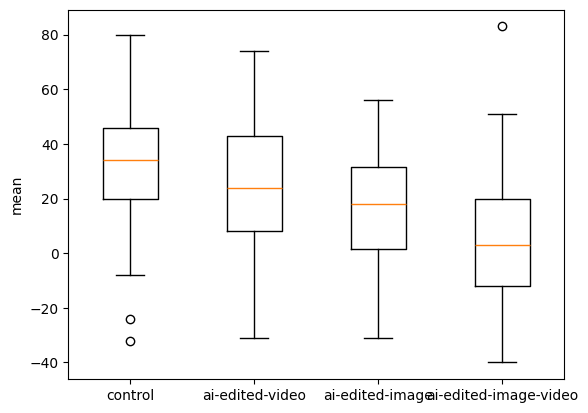

In [209]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.boxplot(data)
ax.set_xticklabels(conditions) 
ax.set_ylabel("mean") 
plt.show()

In [224]:
# Prepare data for plotting according to the specified order and calculate mean and standard error
means = []
errors = []
sds = []
condition_dict = {
    'control': data[0],
    'ai-edited-video': data[1],
    'ai-edited-image': data[2],
    'ai-edited-image-video': data[3]
}

for condition in conditions:
    if condition in condition_dict:
        values = condition_dict[condition]
        mean = np.mean(values)
        # Calculate the standard error as the error bar (standard deviation divided by the square root of the sample size)
        std = np.std(values)
        error = np.std(values) / np.sqrt(len(values))
        means.append(mean)
        sds.append(std)
        errors.append(error)
        
means, errors, sds

([np.float64(32.06122448979592),
  np.float64(24.76),
  np.float64(15.803921568627452),
  np.float64(3.04)],
 [np.float64(3.1413206107829135),
  np.float64(3.224600440364666),
  np.float64(3.0072345944520706),
  np.float64(3.526126486670607)],
 [np.float64(21.989244275480395),
  np.float64(22.801368379989828),
  np.float64(21.475950624117548),
  np.float64(24.933479500462827)])

0 and 2 with id: 0
0 and 3 with id: 1
1 and 3 with id: 2
2 and 3 with id: 3


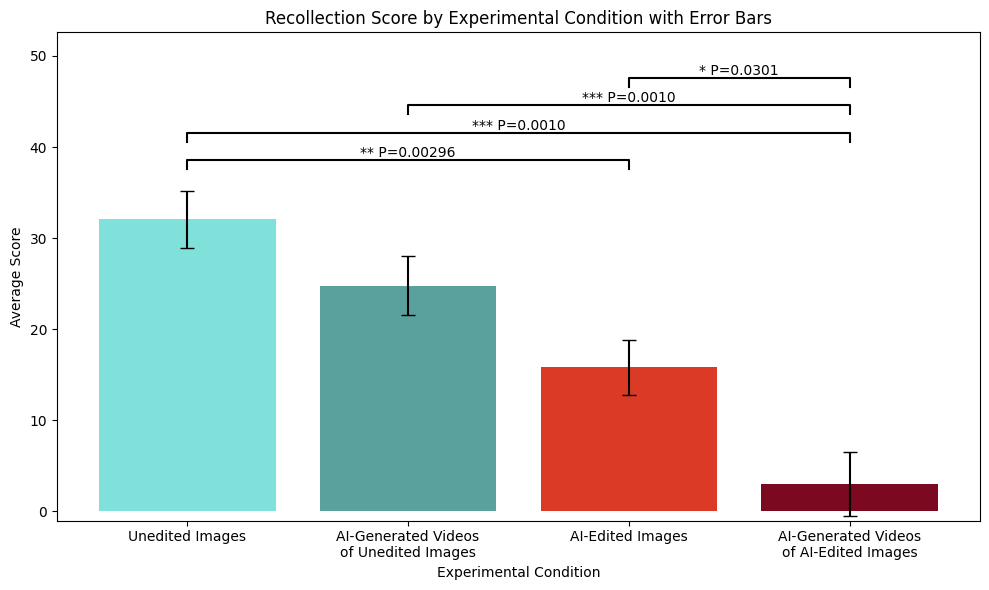

In [293]:
ordered_labels = ['Unedited Images', 'AI-Generated Videos\nof Unedited Images', 'AI-Edited Images', 'AI-Generated Videos\nof AI-Edited Images']
colors = ["#7FE1DA", "#5AA09C", "#DA3A26", "#7B091F"]

 # X positions
x_pos = np.arange(len(conditions))

#           1         2         3         4
# 1  1.000000  0.396745  0.002962  0.001000
# 2  0.396745  1.000000  0.210558  0.001000
# 3  0.002962  0.210558  1.000000  0.030136
# 4  0.001000  0.001000  0.030136  1.000000

# *    P ≤ 0.05
# **   P ≤ 0.01
# ***  P ≤ 0.001
# **** P ≤ 0.0001

# Significance values (p-values) for the significance markers
significance_values = [
    ((0, 2), '** P=0.00296'),
    ((0, 3), '*** P=0.0010'),
    ((1, 3), '*** P=0.0010'),
    ((2, 3), '* P=0.0301'),
]

# Creating the bar plot with error bars
plt.figure(figsize=(10, 6))
bars = plt.bar(x_pos, means, yerr=errors, capsize=5, color=colors)
plt.title('Recollection Score by Experimental Condition with Error Bars')
plt.ylabel('Average Score')
plt.xlabel('Experimental Condition')
plt.xticks(x_pos, ordered_labels)

# Adding significance markers with p-values, separate and not overlapping
y_base_offset = 2  # Base vertical offset for significance lines
y_increment = 3  # Increment for each subsequent significance marker

# Initialize the first y position above the highest bar
current_y_position = max(means) + max(errors) + y_base_offset

for idx, ((i, j), label) in enumerate(significance_values):
    x1, x2 = x_pos[i], x_pos[j]
    print("{1} and {2} with id: {0}".format(idx, x1, x2))
    y = current_y_position
    h, col = 1, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1 + x2) * 0.5, y + h, label, ha='center', va='bottom', color=col)
    current_y_position += y_increment  # Update the y position for the next marker

# Adjust plot limits to make space for significance markers
plt.ylim(-1, current_y_position + y_increment)

# Improve layout
plt.tight_layout()

plt.savefig('immediate_false_mem.png')
#plt.savefig('foo.png', bbox_inches='tight')

# Show the plot
plt.show()

In [341]:
result_induced = result[['condition', *[f"{i}_false_memories_ans" for i in [*range(1,25)] if i in induced]]]
conf_induced = result[['condition', *[f"{i}_false_memories_conf" for i in [*range(1,25)] if i in induced]]]

memories = {
    'control': [],
    'ai-edited-video': [],
    'ai-edited-image': [],
    'ai-edited-image-video': []
}

conf = {
    'control': [],
    'ai-edited-video': [],
    'ai-edited-image': [],
    'ai-edited-image-video': []
}

def tally(l, el):
    return len([*filter(lambda x: x == el, l)])

for i in range(len(result_induced)):
    line = result_induced.iloc[i].tolist()
    true, unsure, false = tally(line, 1), tally(line, 0), tally(line, -1)
    memories[line[0]].append([true, unsure, false])
    
    line_conf = conf_induced.iloc[i].tolist()
    # true, unsure, false = tally(line, 1), tally(line, 0), tally(line, -1)
    tally_conf = [0,0,0]
    for j in range(1, len(line)):
        if(line[j] == 1):
            tally_conf[0] += int(line_conf[j])
        elif (line[j] == 0):
            tally_conf[1] += int(line_conf[j])
        elif (line[j] == -1):
            tally_conf[2] += int(line_conf[j])

    conf[line[0]].append(tally_conf)

In [340]:
# print("SHAPIRO-WILK")
# for c in conditions:
#     print(c, "=>", shapiro(memories[c]))

# print("\nLEVENE", "=>", levene(*[memories[c] for c in conditions]))

print(f_oneway(memories['control'], memories['ai-edited-video'], memories['ai-edited-image'], memories['ai-edited-image-video']))
print(f_oneway(conf['control'], conf['ai-edited-video'], conf['ai-edited-image'], conf['ai-edited-image-video']))

print("\nTUKEY (# of recalled memories)")
for i in range(3):
    print(['non-false', 'unsure', 'false'][i])
    print("#\n", sp.posthoc_tukey([[el[i] for el in memories[c]] for c in conditions]), "\nconf.\n",sp.posthoc_tukey([[el[i] for el in memories[c]] for c in conditions]))
    print()

F_onewayResult(statistic=array([11.29910421,  0.50568642, 12.95450353]), pvalue=array([7.19423901e-07, 6.78798239e-01, 9.35251465e-08]))
F_onewayResult(statistic=array([ 8.49570043,  0.53692024, 13.44256064]), pvalue=array([2.47253483e-05, 6.57518635e-01, 5.16093516e-08]))

TUKEY (# of recalled memories)
non-false
#
           1         2         3         4
1  1.000000  0.176505  0.010405  0.001000
2  0.176505  1.000000  0.671078  0.001700
3  0.010405  0.671078  1.000000  0.048483
4  0.001000  0.001700  0.048483  1.000000

unsure
#
           1         2         3         4
1  1.000000  0.773965  0.900000  0.880243
2  0.773965  1.000000  0.726956  0.900000
3  0.900000  0.726956  1.000000  0.834302
4  0.880243  0.900000  0.834302  1.000000

false
#
           1         2         3         4
1  1.000000  0.501394  0.001785  0.001000
2  0.501394  1.000000  0.107982  0.001000
3  0.001785  0.107982  1.000000  0.140631
4  0.001000  0.001000  0.140631  1.000000



In [176]:
# Prepare data for plotting according to the specified order and calculate mean and standard error
means = []
errors = []
sds = []

for condition in conditions:
    if condition in memories:
        values = memories[condition]
        el1, el2, el3 = [el[0] for el in values], [el[1] for el in values], [el[2] for el in values]
        mean = [np.mean(el1), np.mean(el2), np.mean(el3)]
        # Calculate the standard error as the error bar (standard deviation divided by the square root of the sample size)
        std = [np.std(el1), np.std(el2), np.std(el3)]
        error = [std[0] / np.sqrt(len(el1)), std[1] / np.sqrt(len(el2)), std[2] / np.sqrt(len(el3))]
        means.append(mean)
        sds.append(std)
        errors.append(error)
        
means, errors, sds
means

[[np.float64(7.938775510204081),
  np.float64(1.7959183673469388),
  np.float64(2.2653061224489797)],
 [np.float64(6.98), np.float64(2.18), np.float64(2.84)],
 [np.float64(6.470588235294118),
  np.float64(1.7647058823529411),
  np.float64(3.764705882352941)],
 [np.float64(5.26), np.float64(2.1), np.float64(4.64)]]

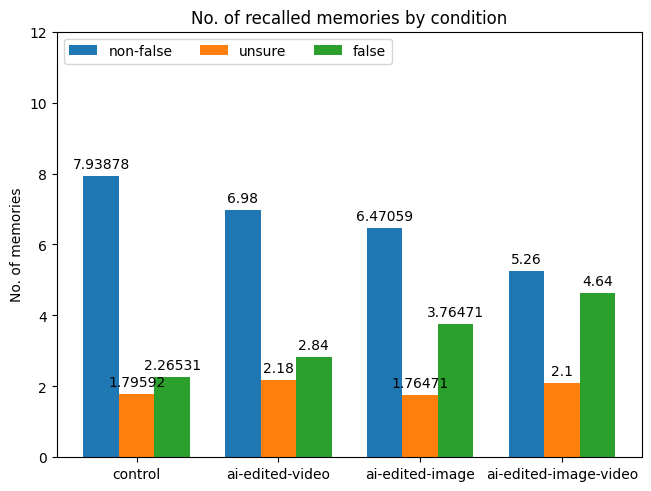

In [190]:
# create a grouped bar chart
# [ control (true), control (unsure), control (false) ] [ai-edited-video (true), ai-edited-video (unsure), ai-edited-video (false)] [ai-edited-image (true), ai-edited-image (unsure), ai-edited-image (false)] [ai-edited-image-video (true), ai-edited-image-video (unsure), ai-edited-image-video (false)]

# data from https://allisonhorst.github.io/palmerpenguins/

# conditions
# penguin_means = {
#     'Bill Depth': (18.35, 18.43, 14.98),
#     'Bill Length': (38.79, 48.83, 47.50),
#     'Flipper Length': (189.95, 195.82, 217.19),
# }

x = np.arange(len(conditions))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

# for attribute, measurement in penguin_means.items():
#     offset = width * multiplier
#     rects = ax.bar(x + offset, measurement, width, label=attribute)
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

cond_dict = {
    'non-false': [el[0] for el in means],
    'unsure': [el[1] for el in means],
    'false': [el[2] for el in means]
}

for attribute, measurement in cond_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No. of memories')
ax.set_title('No. of recalled memories by condition')
ax.set_xticks(x + width, conditions)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 12)

plt.show()